# Data Exploration of Premier League Player and Match Stats

This Jupyter Notebook provides an exploration of player statistics from the English Premier League. The data was scraped from the website [fbref.com](https://fbref.com/en/comps/9/Premier-League-Stats) using a custom Python script employing Selenium WebDriver.

**Goals of Exploration:**

- Analyze player performance metrics across different teams and seasons.
- Identify trends in player statistics over time.
- Uncover potential correlations between various statistical categories (e.g., goals scored vs. minutes played).
- Gain insights that might be valuable for player evaluation, team strategy analysis, or fantasy football decisions.

**Data Structure:**

1 file for the player stats and 1 file for the match stats.

## Libraries and Data

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [166]:
df = pd.read_csv("Premier_League_Player_Stats_Last_4_Seasons.csv")
df.head()

,Season,Team,Player,Nation,Pos,Age,MP,Starts,Min,90s,...,Ast.1,G+A.1,G-PK.1,G+A-PK,xG.1,xAG.1,xG+xAG,npxG.1,npxG+xAG.1,Matches
0,2023-2024,Liverpool,Virgil van Dijk,nl NED,DF,32-268,27.0,27.0,"2,367",26.3,...,0.08,0.15,0.08,0.15,0.08,0.06,0.14,0.08,0.14,Matches
1,2023-2024,Liverpool,Luis Díaz,co COL,FW,27-079,28.0,23.0,"1,924",21.4,...,0.14,0.47,0.33,0.47,0.43,0.16,0.59,0.43,0.59,Matches
2,2023-2024,Liverpool,Alexis Mac Allister,ar ARG,MF,25-099,24.0,23.0,"1,899",21.1,...,0.24,0.38,0.09,0.33,0.10,0.12,0.23,0.07,0.19,Matches
3,2023-2024,Liverpool,Dominik Szoboszlai,hu HUN,MF,23-159,24.0,22.0,"1,821",20.2,...,0.10,0.25,0.15,0.25,0.12,0.22,0.34,0.12,0.34,Matches
4,2023-2024,Liverpool,Mohamed Salah,eg EGY,FW,31-291,23.0,21.0,"1,906",21.2,...,0.42,1.18,0.57,0.99,0.78,0.44,1.22,0.55,0.99,Matches


In [167]:
print(df.shape)

(2943, 36)


## Initial Data Cleaning

In this section we will Pperform some basic cleaning steps (handling missing values, converting data types, etc.). Let's start by checking the data types of the dataset.

In [168]:
df.dtypes

Season         object
Team           object
Player         object
Nation         object
Pos            object
Age            object
MP            float64
Starts        float64
Min            object
90s           float64
Gls           float64
Ast           float64
G+A           float64
G-PK          float64
PK            float64
PKatt         float64
CrdY          float64
CrdR          float64
xG            float64
npxG          float64
xAG           float64
npxG+xAG      float64
PrgC          float64
PrgP          float64
PrgR          float64
Gls.1         float64
Ast.1         float64
G+A.1         float64
G-PK.1        float64
G+A-PK        float64
xG.1          float64
xAG.1         float64
xG+xAG        float64
npxG.1        float64
npxG+xAG.1    float64
Matches        object
dtype: object

We can see that there are multiple columns with the same name. This is because the data is structured in a hierarchical manner, with multiple levels of columns, for example: Playing Time, Performance, Expected, Progression, Per 90 Minutes. We have to update the column names to reflect this hierarchy.

In [169]:
df.rename(columns={'Gls.1': 'Gls/90'}, inplace=True)
df.rename(columns={'Ast.1': 'Ast/90'}, inplace=True)
df.rename(columns={'G+A.1': 'G+A/90'}, inplace=True)
df.rename(columns={'G-PK.1': 'G-PK/90'}, inplace=True)
df.rename(columns={'G+A-PK.1': 'G+A-PK/90'}, inplace=True)
df.rename(columns={'xG.1': 'xG/90'}, inplace=True)
df.rename(columns={'xAG.1': 'xA/90'}, inplace=True)
df.rename(columns={'xG+xA.1': 'xG+xA/90'}, inplace=True)
df.rename(columns={'npxG.1': 'npxG/90'}, inplace=True)
df.rename(columns={'npxG+xAG.1': 'npxG+xA/90'}, inplace=True)

In [170]:
def clean_minutes(min_str):
    """Removes commas, converts to integer, and handles NaN values."""
    if pd.isna(min_str):  # Check for NaN
        return min_str  # Return NaN as is
    return int(min_str.replace(',', ''))

df['Min'] = df['Min'].apply(clean_minutes)

We can remove the "Matches" column, as it contains the same value for all rows.

In [171]:
df = df.drop(columns=['Matches'])

While the player data is being scraped, the code seems to gather some unwanted column headers. This occurs when there are players in the squad that have not featured in any game, so their statistics are not available and they are displayed in a separate "sub-table" within the main table. See the example below: https://fbref.com/en/squads/822bd0ba/Liverpool-Stats

To handle this issue, we will just remove any row, that does not have a nationality and a position, as these should be required fields for all players.

In [172]:
df = df.dropna(subset=['Nation', 'Pos'], how='all')
print(df.shape)

(2787, 35)


A total of "" rows have now been sucessfully removed.

We could also clean up the Nation column as it contains the flag of the country and the name of the country. We can just keep one of these values.

In [173]:
def remove_lowercase(text):
    for i in range(len(text)):
        if text[i].isupper():  # Find the first uppercase letter
            return text[i:]  # Return the string from that point onwards
    return np.NaN  # If no uppercase letters are found, return NA

df['Nation'] = df['Nation'].astype(str)

# Apply the function to the 'Nation' column
df['Nation'] = df['Nation'].apply(remove_lowercase)
df['Nation'].unique()

array(['NED', 'COL', 'ARG', 'HUN', 'EGY', 'BRA', 'ENG', 'URU', 'FRA',
       'JPN', 'POR', 'SCO', 'CMR', 'IRL', 'GRE', 'NIR', 'WAL', 'ESP',
       'POL', 'NOR', 'GER', 'UKR', 'BEL', 'ITA', 'GHA', 'EST', 'SUI',
       'CRO', 'JAM', 'SWE', 'BFA', 'AUS', 'KOR', 'SEN', 'MLI', 'DEN',
       'ROU', 'ISR', 'MAR', 'TUN', 'CIV', 'TUR', nan, 'CZE', 'MEX', 'ALG',
       'PAR', 'SVK', 'ECU', 'GAB', 'AUT', 'IDN', 'SRB', 'ALB', 'FIN',
       'USA', 'NGA', 'CAN', 'NZL', 'COD', 'IRN', 'GRN', 'GNB', 'CRC',
       'ZIM', 'RSA', 'ISL', 'TOG', 'KVX', 'CHI', 'BIH', 'IRQ', 'GUI',
       'ZAM', 'MNE', 'LBR', 'MSR', 'VEN', 'DOM', 'ANG', 'SLE', 'THA',
       'MKD', 'MTN', 'BUL', 'SKN'], dtype=object)

The 'Age' column contains the age of the player in years and days. To simplify the analysis, we can convert this to just the age in years.

In [174]:
def extract_year(age_str):
    """Extracts the year from the age string, handling NaN values."""
    if pd.isna(age_str):  # Check for NaN
        return age_str  # Return NaN as is
    return int(age_str.split('-')[0])

df['Age'] = df['Age'].apply(extract_year)

## Exploratory Analysis

- Analyze player performance by team/position (e.g., average goals scored by forwards for each team).
- Visualize trends over time (if data spans multiple seasons).
- Investigate correlations between statistics (e.g., using scatter plots).

In [196]:
season_sum_xg = df.groupby('Season')['xG'].sum()
season_sum_xg = season_sum_xg.reset_index(name='Total_xGoals')

season_sum_goals = df.groupby('Season')['Gls'].sum()
season_sum_goals = season_sum_goals.reset_index(name='Total_Goals')

season_sum_assists = df.groupby('Season')['xAG'].sum()
season_sum_assists = season_sum_assists.reset_index(name='Total_xAst')

season_sum_xa = df.groupby('Season')['Ast'].sum()
season_sum_xa = season_sum_xa.reset_index(name='Total_Ast')

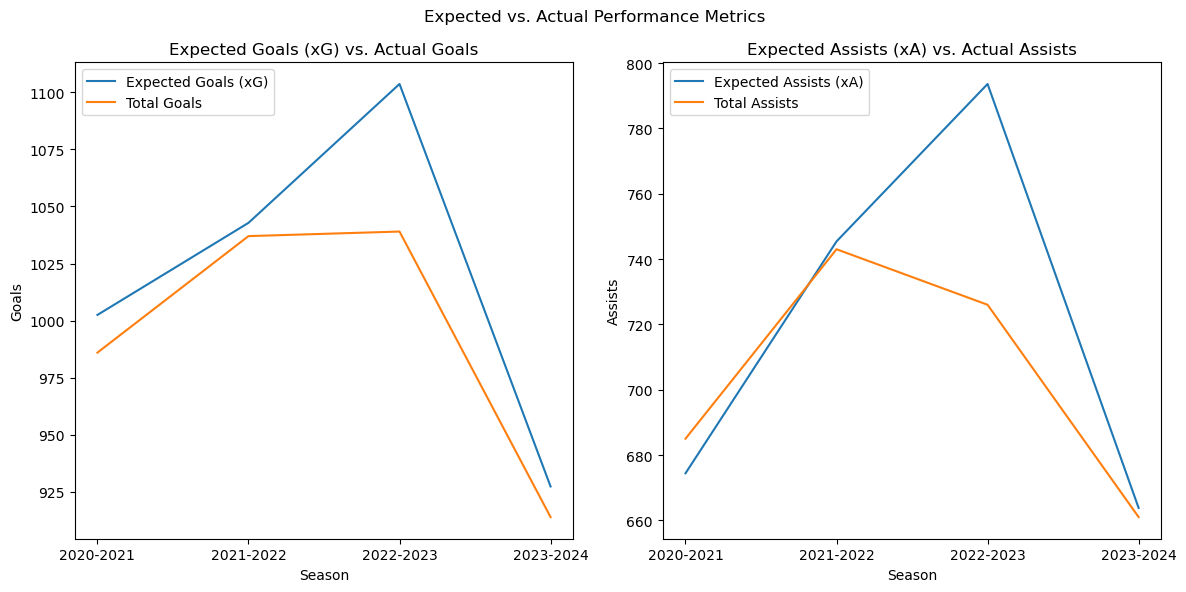

In [197]:
combined_goals = pd.merge(season_sum_xg, season_sum_goals, on='Season') 

# Combine assists data 
combined_ast = pd.merge(season_sum_assists, season_sum_xa, on='Season')

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# -------- Plot 1: Goals --------
sns.lineplot(x="Season", y="Total_xGoals", data=combined_goals, label="Expected Goals (xG)", ax=ax1)
sns.lineplot(x="Season", y="Total_Goals", data=combined_goals, label="Total Goals", ax=ax1)
ax1.set_title('Expected Goals (xG) vs. Actual Goals')
ax1.set_xlabel('Season')
ax1.set_ylabel('Goals')

# -------- Plot 2: Assists --------
sns.lineplot(x="Season", y="Total_xAst", data=combined_ast, label="Expected Assists (xA)", ax=ax2)
sns.lineplot(x="Season", y="Total_Ast", data=combined_ast, label="Total Assists", ax=ax2)
ax2.set_title('Expected Assists (xA) vs. Actual Assists')
ax2.set_xlabel('Season')
ax2.set_ylabel('Assists')

# Common Adjustments
fig.suptitle('Expected vs. Actual Performance Metrics')
plt.tight_layout()
plt.show()

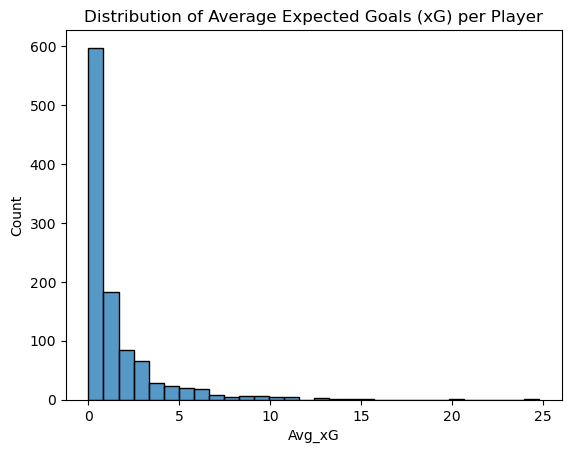

In [182]:
# group by player
player_avg_xg = df.groupby('Player')['xG'].mean()
player_avg_xg = player_avg_xg.reset_index(name='Avg_xG')

# Histogram
sns.histplot(player_avg_xg['Avg_xG'], bins=30)
plt.title('Distribution of Average Expected Goals (xG) per Player')
plt.show()

## Conclusion

- Summarize key findings from the exploration.
- Discuss potential limitations of the data or scraping methodology.
- Outline future exploration ideas.